In [163]:
#Import relevant packages
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle #To unpack the file
import matplotlib.pyplot as plt #For plotting
import torch.optim as optim #Parameter optimization functions
from torch.utils.data import Dataset, DataLoader, ConcatDataset #Creating the Dataset and DataLoader

## Create the dataLoader

The data is pickled which means that the objects are converted into a byte stream. We will unpickle the object to get back the original data. (https://www.cs.toronto.edu/~kriz/cifar.html). Below is the Dataset class which can be used in torch.utils.data.dataLoader

In [164]:
class cifarDataset(Dataset):
    def __init__(self, filePath, transform=None):
        self.images, self.labels = self.__loadImages__(filePath)

    def __loadImages__(self, filePath):
        object = self.__unpickle__(filePath) #Extract our dataset
        X = object[b'data']
        X = X.reshape(len(object[b'data']),3,32,32) #Reshape to Color and the corresponding XY coordinates
        #X = X.transpose(0,2,3,1) #Transpose to X Y C
        l = object[b'labels']
        return(X,l)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        sample = {'image':self.images[idx], 'label':self.labels[idx]}
        return(sample)
        
    def __unpickle__(self, file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
        

In [165]:
def showImage(img, label='Not labeled'):
    img = img.permute(1,2,0)
    plt.imshow(img)
    plt.xlabel(label)
    plt.show()

In [166]:
def getLabel(number):
    names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    return(names[number])

## Load the dataset

In [167]:
batch1 = cifarDataset(filePath='data/cifar-10-batches-py/data_batch_1')
batch2 = cifarDataset(filePath='data/cifar-10-batches-py/data_batch_2')
batch3 = cifarDataset(filePath='data/cifar-10-batches-py/data_batch_3')
batch4 = cifarDataset(filePath='data/cifar-10-batches-py/data_batch_4')
batch5 = cifarDataset(filePath='data/cifar-10-batches-py/data_batch_5')

In [168]:
#Concatenate our training dataset
batches = torch.utils.data.ConcatDataset([batch1])

In [169]:
#Use the dataLoader to extract images from our dataset
trainloader = DataLoader(batches, batch_size=1, shuffle=True, num_workers=4)

In [170]:
testBatch = cifarDataset(filePath='data/cifar-10-batches-py/test_batch')
#Create the dataLoader for our test set
testloader = DataLoader(testBatch, batch_size=1, shuffle=True, num_workers=4)

Batch information:  0 torch.Size([1, 3, 32, 32]) tensor([8])


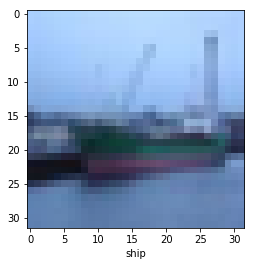

In [171]:
#Try using the dataloader to print one image
for i_batch, sample_batched in enumerate(trainloader):
    print("Batch information: ", i_batch, sample_batched['image'].size(), sample_batched['label'])
    showImage(sample_batched['image'][0],getLabel(sample_batched['label'][0]))
    break

## Create a CNN model

In [206]:
#Define the neural net.
class CNN(nn.Module):
    
    def __init__(self):
        #Define the network
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5) #We have 3 channels. Output 8 feature map with 5x5 kernel
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(8, 15, 5) #Expand to 15 feature maps
        self.fc1 = nn.Linear(15 * 5 * 5, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 15 * 5 * 5)
        x = F.relu(self.fc1(x))
        return(x)


## Train the network

In [207]:
#Initialize the neural net
classifier = CNN()
print(classifier)
#Create the optim
optimizer = optim.SGD(classifier.parameters(), lr=0.2)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 15, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=375, out_features=10, bias=True)
)
